# InvertibleNetworks.jl and Normalizing Flows 
We will layout the basic theory behind Normalizing Flows (NFs) and how to use the implementations in InvertibleNetworks.jl to train and sample from a basic Normalizing Flow.



## Normalizing Flows

In a landscape that is dominated by GANs, Normalizing Flows offer a noteworthy alternative for generative models. As generative models, Normalizing Flows offer straight forward training thanks to their exact likelihood evaluation capabilities, and also have fast sampling at test time. The intrinsic invertibility of these models allows for memory efficient training which was their initial motivation of their implementation in  ``InvertibleNetworks.jl``.

The formula central to Normalizing Flows and other flow models is the change of variables formula. 

## Change of variables formula

Normalizing Flows are based on the [change of variables formula](https://cedricvillani.org/sites/dev/files/old_images/2012/08/preprint-1.pdf):

$$p_x(x) = p_z(f_\theta(x)) \, \left| \, \det \frac{\partial f_\theta}{\partial x}\right|.$$

Where $p_x$ is called the target distribution (typically a complex/multimodal distribution), $p_z$ is called the base distribution and is a simple distribution, and $f_\theta$ is a function that is capable of tranforming samples from the $\mathbf{X}$ space to $\mathbf{Z}$ space.

The derivation of this formula can be found in many [places](https://en.wikipedia.org/wiki/Probability_density_function#Dependent_variables_and_change_of_variables) as this is a well known relation that comes from the fact that the density of a sample in the $\mathbf{X}$ space must be equal to the density of that sample transformed into the $\mathbf{Z}$ space even if the volume of the sample changes. The Jacobian term is what controls for this change in volume. 

Practically, this formula allows us to evaluate the likelihood of a sample $x$ after transforming through a function $f_{\theta} : \mathbf{X} \rightarrow
 \mathbf{Z}$. 
 
To see why we would want to do this, imagine that $p_x(x)$ represents the distribution of human faces. Then it is clear that we can't evaluate $p_x(x)$ for a given face $x$ but what if we were given a magical $f_{\theta}$ that transforms the face $x$ into Normally distributed white noise $z$. Then the change of variable formula allows us to evaluate the likelihood in this simple distribution (log-likelihood is just the $\ell_2$ norm) as long as we control for the change of volume caused by the function $f_{\theta}$ in other words the determinant of the Jacobian term $\left| \det \frac{\partial f_\theta}{\partial x} \right|$. 

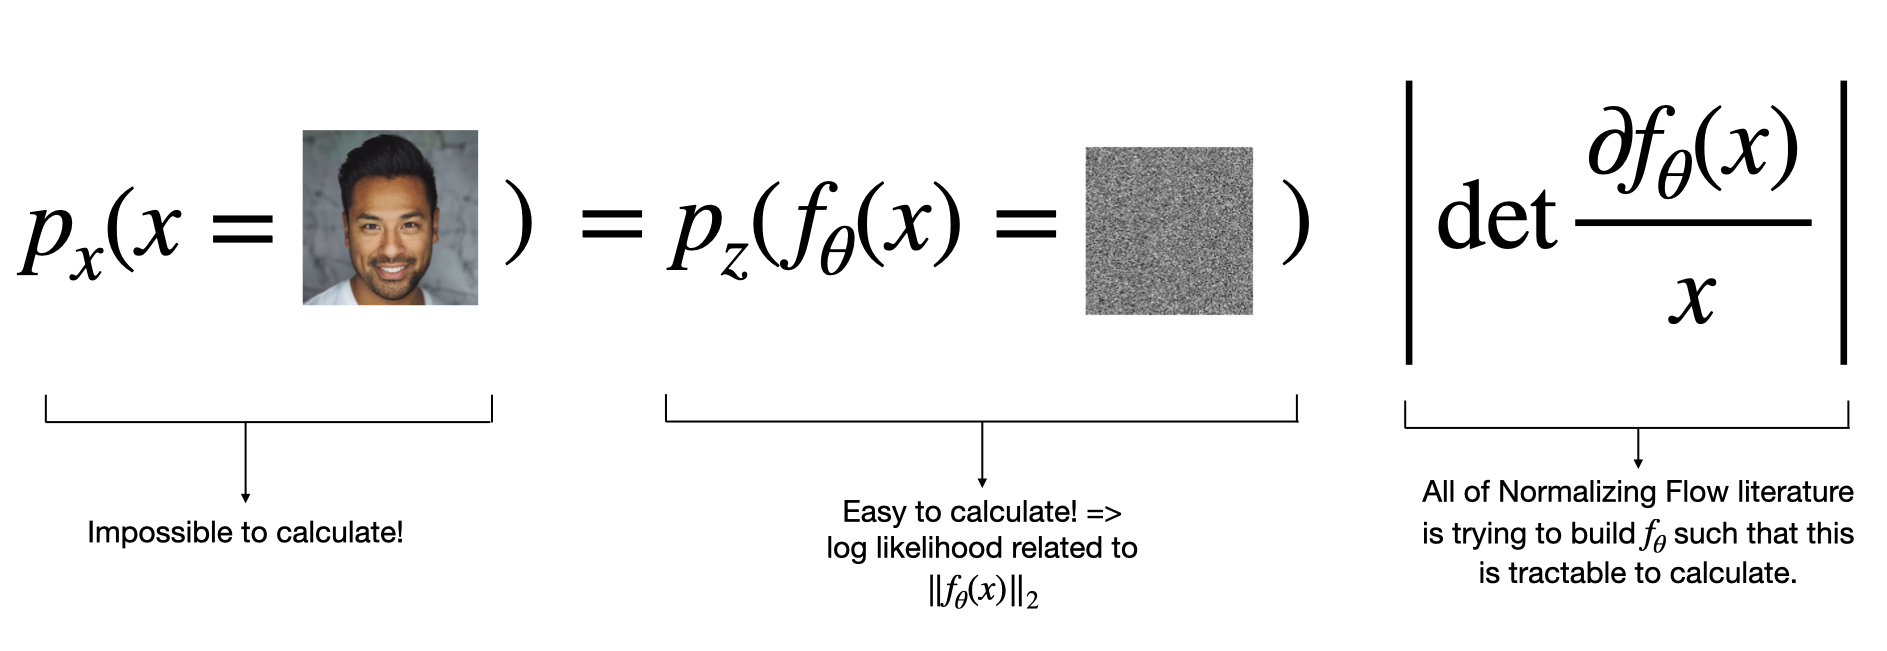


This likelihood evaluation of a complex distribution in a simple/known distribution is what gives us a maximum likelihood framework for training our parameterized functions $f_{\theta}$ which we will parameterize as a Normalizing Flow. 

## Training a Normalizing Flow 

Normalizing Flow training is based on likelihood maximization of the parameterized model $f_{\theta}$ under the log-likelihood of samples from a data distribution ${x} \sim p_{x}(x)$: 

$$\underset{\mathbf{\theta}}{\operatorname{argmax}} \mathbb E_{{x} \sim p_{x}(x)} [\log p_{x}(x)]. $$

We make this a minimization problem by looking at the negative log-likelihood and then use the change of variabes formula to express the likelihood on a transformed sample $f_\theta({x})$ in the latent space $Z$ which we will take to be the standard Normal distribution $z \sim \mathcal{N}(0,I)$:

$$\underset{\mathbf{\theta}}{\operatorname{argmin}}   E_{{x}  \sim p_{x}(x)} -\log p_{x}(x)  = 
  \underset{\mathbf{\theta}}{\operatorname{argmin}}   E_{{x}  \sim p_{x}(x)} 
  -\log \left[ p_{z}(f_\theta(x)) \, \left|\det \frac{\partial f_\theta}{\partial x}\right| 
  \right] 
 $$
 $$
 = 
   \underset{\mathbf{\theta}}{\operatorname{argmin}}   E_{{x}  \sim p_{x}(x)} 
  -\log p_{z}(f_\theta(x)) \, -\log \, \left|\det \frac{\partial f_\theta}{\partial x}\right|.
$$

Note that since we are evaluating the negative log-likelihood of a sample which is Normally distributed $-\log p_{z}(f_\theta(x))$ we simply evaluate its $\ell_2$ norm
$$
= \underset{\mathbf{\theta}}{\operatorname{argmin}}   E_{{x} \sim p_{x}(x)}  \left[\frac{1}{2}\|f_\theta({x})\|_2^2 - \log \, \left| \, \det \frac{\partial f_\theta}{\partial x} \, \right| \, \right].$$

We evaluate the expectation $E_{{x} \sim p(x)}$ with the Monte Carlo approximation using samples from a training dataset $X_{train}$ that has been sampled from the true distribution:

$$\underset{\mathbf{\theta}}{\operatorname{argmin}}   \frac{1}{N} \sum_{x \in X_{train}} \left[\frac{1}{2}\|f_\theta({x})\|_2^2 - \log \, \left| \, \det \frac{\partial f_\theta}{\partial x} \, \right| \, \right]. $$

This is our final training objective and it tells an extremely intuitive story: apply your network to your data $\hat z = f_\theta(x)$ and minimize its $\ell_2$ norm while also maximizing the term involving the deteriminant of the Jacobian. If we intepret this Jacobian term as measuring the "expansion" of density space caused by the network then we are making sure that the learned probability does not collapse on single modes giving a peaky distribution. 

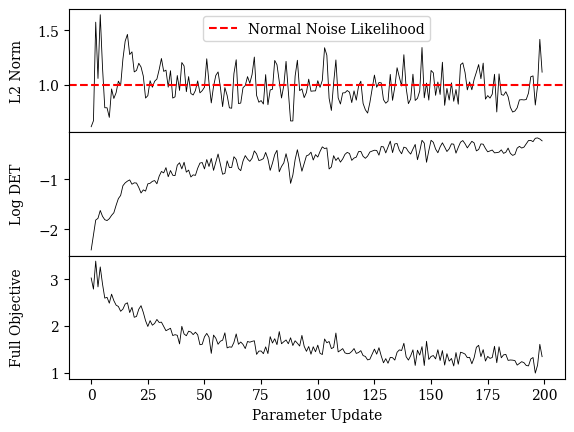


The above figure shows a typical scenario in Normalizing Flow training where we are tracking the values of the two terms that make up the full objective. In the first row, we show the $\ell_2$ norm of samples, and in the second row we show the value of the Jacobian term. At first glance we would think that minimizing the $\ell_2$ norm of samples would simply train the network to map samples to zero. But from studying a training log of these terms we can see that the $\ell_2$ norm of samples instead starts to converge to the value of the expected norm of samples that come from a Normal distribution namely ``1``. This is thanks to the Jacobian term which is continually battling to "expand" the output distribution.  




## Loss function implementation. 

Lets implement this loss function and we will see that it is straightforward

In [20]:
using InvertibleNetworks
using LinearAlgebra
using PyPlot
using Flux
using Random

import Flux.Optimise: ADAM, update!

In [3]:
function loss(f, X)
    batch_size = size(X)[end] 
    
    Z, logdet = f.forward(X)
    
    # Likelihood under Normal Gaussian training (ignoring some constants)
    l2_loss = 0.5 * norm(Z)^2 / batch_size 
    
    # Gradient under Normal Gaussian training
    dZ = Z / batch_size                   
    
    # Sets gradients of f wrt output and also set gradient of logdet terms
    f.backward(dZ, Z)  
    
    return l2_loss, logdet
end

loss (generic function with 1 method)

Breaking down the function ``loss(f,X)``: 
- Line 4: We pass our input tensor ``X`` and pass it through the forward network which will return the output ``Z`` and the value of the log determinant of the Jacobian at that input $\left| \det \frac{\partial f_\theta}{\partial x} \right|$ which is calculated on the fly using the given formula for each layer of the flow. \
    Note: tensor size can be four dimensional = ``(x,y,n_channel,n_batch)`` or five dimensional = ``(x,y,z,n_channel,n_batch)``
    

- Line 7: Calculate the derivative of the output ``Z`` wrt to the loss function. Since we are training towards a Normal distribution,the loss function is the $\ell_2$ norm so the gradient is the variable itself).

- Line 9: Backprogagate the derivative of ``Z`` through the network. Calling ``G.backward`` will set all the gradients of the trainable parameters in f. Internally, the gradients of the Jacobian term are calculated and taken into account for the parameters gradients.  We can access these parameters and their gradients with ``get_params`` and update them with the optimizer of our choice.

Since the network is invertible we do not need to save intermediate activations to calculate the gradient. Instead, we only provide the ``f.backward`` function with the final output ``Z`` and it will recalculate the intermediate states to calculate the gradients at each layer while backpropagating the residual ``dZ``. This makes network training extremely memory efficient while incuring only the cost of one reverse evaluation of the network.

All layers and modules implemented in InvertibleNetworks.jl have hand-made gradients which allow us to not have to rely on Automatic Differentiation (AD). But when desired a layer that uses AD can be swapped in at any stage of the flow layers. 

## Tutorial: learning a toy distribution

For this example, we will learn to sample from the Rosenbrock distribution with two parameters. Accessible in ``InvertibleNetworks.jl``
using its colloquial name: the "banana" distribution

In [4]:
n_train = 60000;
X_train = sample_banana(n_train);

# (nx, ny, n_channels, n_samples) Note: we put 2 dimensions as channesemicolonls
size(X_train) 

LoadError: [91mUndefVarError: sample_banana not defined[39m

Lets visualize what the target distribution looks like.

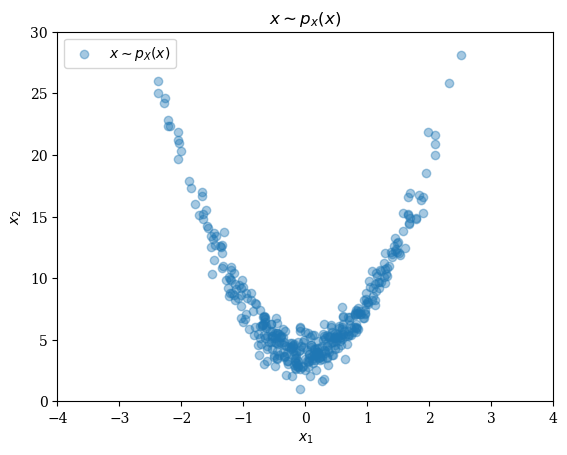

In [23]:
plot_num = 400
fig = figure(); title(L"x \sim p_x(x)");
scatter(X_train[1,1,1,1:plot_num], X_train[1,1,2,1:plot_num]; alpha=0.4, label = L"x \sim p_{X}(x)");
xlabel(L"x_1"); ylabel(L"x_2");
xlim(-4,4); ylim(0,30);
legend();

## Initialize Normalizing Flow (GLOW)
InvertibleNetworks.jl contains implementations of various Normalizing Flows. For this example we will use one of the state of the art models: the [GLOW](https://proceedings.neurips.cc/paper/2018/file/d139db6a236200b21cc7f752979132d0-Paper.pdf) architecture.

The the specific layers that GLOW architecture implements are:
* Affine couplying layer from Real-NVP
* Ability to activate multiscale for efficient training and compressive behavior in latent code $z$ 
* ActNorms for stable training   
* 1x1 Convolutions for channel mixing between affine couplying layers  


In [5]:
nx          = 1  # Express 2D variables as 2 channels
ny          = 1  # Express 2D variables as 2 channels

#network architecture
n_in        = 2  # Express 2D variables as 2 channels
n_hidden    = 64 # Number of hidden convolution channels in CNN network of coupling layer
levels_L    = 1  # Number of multiscale levels as described in Real-NVP
flowsteps_K = 10 # Number of flow steps at each level. Total depth of NF is = K*L

f = NetworkGlow(n_in, n_hidden, levels_L, flowsteps_K);
#f = f |> gpu 

Now, we can write out out training loop. Here there is nothing special about our optimization. Once, we have the parameters of our model with``get_params(f) `` we update them as usual with our optimizer of choice. 

Note: to train on GPU we simply need to load our model and data into the GPU with ``|> gpu``

In [6]:
# Training parameters
batch_size = 300
maxiter    = cld(n_train, batch_size)

lr = 1f-3
opt = ADAM(lr)

loss_l2_list    = zeros(maxiter)
loss_logdet_list = zeros(maxiter)

for j = 1:maxiter
    idx = ((j - 1) * batch_size + 1):(j * batch_size)
    
    X = X_train[:,:,:,idx]
    #X = X |> gpu
    
    # Sets gradients of f and returns objective values  
    losses = loss(f, X) 
    
    loss_l2_list[j]    = losses[1]
    loss_logdet_list[j] = losses[2]
     
    for p in get_params(f) 
        update!(opt,p.data,p.grad)
    end
end

Iter : iteration=1/200, batch=; f l2 = 0.626249745686849; f lgdet = -2.4786009788513184; f nll objective = 3.104850724538167
Iter : iteration=2/200, batch=; f l2 = 0.7937405395507813; f lgdet = -2.4498519897460938; f nll objective = 3.2435925292968752
Iter : iteration=3/200, batch=; f l2 = 0.6455147806803385; f lgdet = -2.4261255264282227; f nll objective = 3.071640307108561
Iter : iteration=4/200, batch=; f l2 = 0.5650841776529948; f lgdet = -2.394686222076416; f nll objective = 2.9597703997294107
Iter : iteration=5/200, batch=; f l2 = 0.5567454528808594; f lgdet = -2.362407922744751; f nll objective = 2.9191533756256103
Iter : iteration=6/200, batch=; f l2 = 0.6116364542643229; f lgdet = -2.3232505321502686; f nll objective = 2.9348869864145914
Iter : iteration=7/200, batch=; f l2 = 0.6417168680826822; f lgdet = -2.2878828048706055; f nll objective = 2.929599672953288
Iter : iteration=8/200, batch=; f l2 = 0.6422951253255208; f lgdet = -2.2505946159362793; f nll objective = 2.8928897

Iter : iteration=66/200, batch=; f l2 = 0.9023507690429687; f lgdet = -0.32555899024009705; f nll objective = 1.2279097592830657
Iter : iteration=67/200, batch=; f l2 = 0.9868181355794271; f lgdet = -0.35575708746910095; f nll objective = 1.3425752230485282
Iter : iteration=68/200, batch=; f l2 = 0.9177785237630208; f lgdet = -0.2846050560474396; f nll objective = 1.2023835798104603
Iter : iteration=69/200, batch=; f l2 = 0.9107439168294271; f lgdet = -0.2192998230457306; f nll objective = 1.1300437398751577
Iter : iteration=70/200, batch=; f l2 = 0.9605732218424479; f lgdet = -0.25752508640289307; f nll objective = 1.218098308245341
Iter : iteration=71/200, batch=; f l2 = 0.9643426513671876; f lgdet = -0.20860826969146729; f nll objective = 1.1729509210586548
Iter : iteration=72/200, batch=; f l2 = 0.7821087646484375; f lgdet = -0.2382298707962036; f nll objective = 1.020338635444641
Iter : iteration=73/200, batch=; f l2 = 0.8306803385416667; f lgdet = -0.2404865324497223; f nll objec

Iter : iteration=130/200, batch=; f l2 = 1.1976361083984375; f lgdet = -0.05469292402267456; f nll objective = 1.252329032421112
Iter : iteration=131/200, batch=; f l2 = 0.9581065877278646; f lgdet = -0.10645470023155212; f nll objective = 1.0645612879594166
Iter : iteration=132/200, batch=; f l2 = 1.0652803548177083; f lgdet = -0.08647704124450684; f nll objective = 1.1517573960622152
Iter : iteration=133/200, batch=; f l2 = 1.0046726481119792; f lgdet = -0.13483694195747375; f nll objective = 1.139509590069453
Iter : iteration=134/200, batch=; f l2 = 0.8975691731770833; f lgdet = -0.26352235674858093; f nll objective = 1.1610915299256641
Iter : iteration=135/200, batch=; f l2 = 1.1105368041992187; f lgdet = -0.26169735193252563; f nll objective = 1.3722341561317444
Iter : iteration=136/200, batch=; f l2 = 1.1268472290039062; f lgdet = -0.2576199173927307; f nll objective = 1.384467146396637
Iter : iteration=137/200, batch=; f l2 = 0.872972412109375; f lgdet = -0.2187599241733551; f n

Iter : iteration=194/200, batch=; f l2 = 1.0986771647135416; f lgdet = 0.01294448971748352; f nll objective = 1.085732674996058
Iter : iteration=195/200, batch=; f l2 = 0.9344514973958333; f lgdet = -0.022910118103027344; f nll objective = 0.9573616154988607
Iter : iteration=196/200, batch=; f l2 = 1.0075590006510418; f lgdet = -0.053606510162353516; f nll objective = 1.0611655108133953
Iter : iteration=197/200, batch=; f l2 = 1.1768667602539062; f lgdet = -0.043646544218063354; f nll objective = 1.2205133044719696
Iter : iteration=198/200, batch=; f l2 = 0.9757251993815104; f lgdet = -0.02974677085876465; f nll objective = 1.005471970240275
Iter : iteration=199/200, batch=; f l2 = 0.9325828043619792; f lgdet = -0.09457075595855713; f nll objective = 1.0271535603205364
Iter : iteration=200/200, batch=; f l2 = 1.091072489420573; f lgdet = -0.06672555208206177; f nll objective = 1.1577980415026348


## Understanding a Normalizing Flow training log 
There are various ways to decide how long to train a NF:
- train your network until convergence of objective
- use earlystopping to prevent overfitting with a traditional leave out test set.  
- check normality of $\hat z = f_{\theta}(x)$ with qq plots 
- as a heuristic simply observe $\hat z = f_{\theta}(x)$ until it looks normal to your eyes. 

Regardless of your choice it is helpful to plot your training log by separating the two terms of the objective: the $\ell_2$ norm term and the Jacobian term. This allows us to better diagnose problems in our training process.

In [2]:
# Expectation of likelihood of gaussian noise
gt_l2 = 0.5 * nx * ny * n_in 

fig, axs = subplots(3, 1, sharex=true)
fig.subplots_adjust(hspace=0)

axs[1].plot(loss_l2_list, color="black", linewidth=0.6); 
axs[1].axhline(y=gt_l2,color="red",linestyle="--",label="Normal Noise Likelihood")
axs[1].set_ylabel("L2 Norm")
axs[1].yaxis.set_label_coords(-0.09, 0.5)
axs[1].legend()

axs[2].plot(loss_logdet_list, color="black", linewidth=0.6); 
axs[2].set_ylabel("Log Det Jac") 
axs[2].yaxis.set_label_coords(-0.09, 0.5) 

axs[3].plot(loss_l2_list - loss_logdet_list, color="black", linewidth=0.6); 
axs[3].set_ylabel("Full Objective") 
axs[3].yaxis.set_label_coords(-0.09, 0.5)
axs[3].set_xlabel("Parameter Update") 

LoadError: [91mUndefVarError: nx not defined[39m

## Testing a Normalizing Flow 
Since we have access to samples from the banana distribution $p_x(x)$ we can verify that generative samples from our trained network  $\hat x = f^{-1}_\theta(z)$  look like they come from $p_x(x)$. We can verify this visually (easy since this is a 2D dataset).

First we take samples from the base distribution $z \sim N(0,I) $

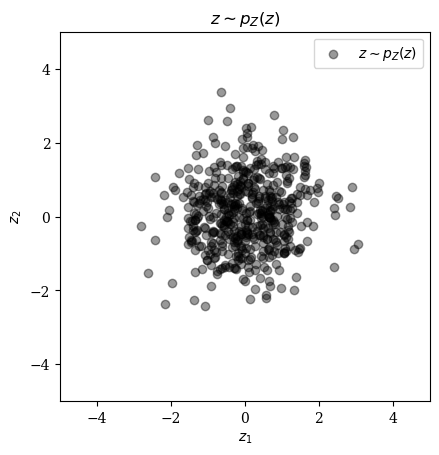

In [9]:
num_test_samples = 500;
Z_test = randn(Float32,nx,ny,n_in,num_test_samples);

fig = figure(); title(L"z \sim p_{Z}(z)")
ax = fig.add_subplot(111);
scatter(Z_test[1,1,1,:], Z_test[1,1,2,:]; alpha=0.4, color="black", label = L"z \sim p_{Z}(z)");
xlabel(L"z_1"); ylabel(L"z_2");
xlim(-5,5); ylim(-5,5);
legend(); 
ax.set_aspect(1);

Pass Normal samples $z \sim N(0,I)$ through the inverse network $\hat x = f^{-1}_\theta(z)$ to make new generative samples. 

In [11]:
X_test = f.inverse(Z_test);

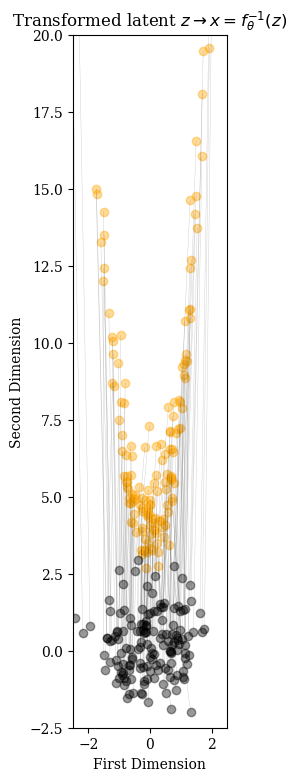

In [14]:
obs_num = 150
start_points = [(Z_test[1,1,1,i], Z_test[1,1,2,i]) for i in 1:obs_num]
end_points = [(X_test[1,1,1,i], X_test[1,1,2,i]) for i in 1:obs_num]

fig = figure(figsize=(7,9)); title(L"Transformed latent $z \rightarrow x=f^{-1}_\theta(z)$");
ax = fig.add_subplot(111)

for line in zip(start_points, end_points)
    plot([line[1][1],line[2][1]], [line[1][2] ,line[2][2]], alpha=0.2, linewidth=0.3, color="black")
    scatter(line[1][1], line[1][2], marker="o",alpha=0.4, color="black")
    scatter(line[2][1], line[2][2], marker="o",alpha=0.4, color="orange")
end
xlabel("First Dimension"); ylabel("Second Dimension");
ylim(-2.5,20); xlim(-2.5,2.5); ax.set_aspect(1)

Finally, visually compare generative samples with samples from the ground truth density $x \sim p_x(x) $

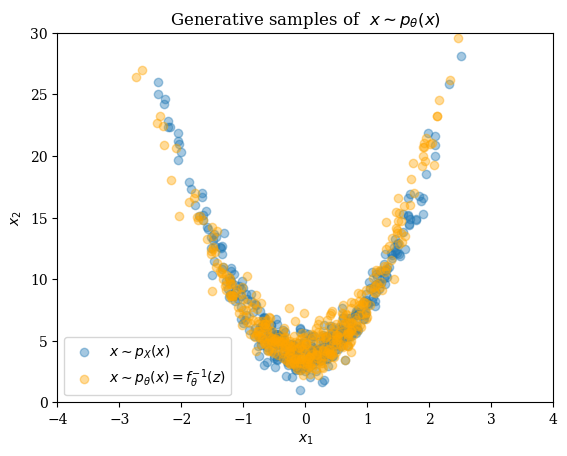

In [15]:
fig = figure(); title(L"Generative samples of  $x \sim p_{\theta}(x)$")
scatter(X_train[1,1,1,1:400], X_train[1,1,2,1:400]; alpha=0.4, label = L"x \sim p_{X}(x)");
scatter(X_test[1,1,1,1:400], X_test[1,1,2,1:400]; alpha=0.4, color="orange", label = L"x \sim p_{\theta}(x) = f_\theta^{-1}(z)");
xlabel(L"x_1"); ylabel(L"x_2");
xlim(-4,4); ylim(0,30);
legend();

# Application 1: Linear inverse problem with Gaussian additive noise

As a stylized example, we will solve an inverse problem given linear measurements of a model $x$ through a compressive sensing operator $A$. We will also add Gaussian additive noise and take that to be our observed data.   
$$y = Ax + \epsilon$$

Even though we will chose an $A$ that might be invertible, the added noise makes this problem ill-posed. Therefore for a given datapoint $y$ there is not a single model $x$ which solves the inverse problem. Instead there is a whole distribution of models $x \sim p(x|y)$ (a conditional distribution) that explains the data. In this context, this is also called the posterior distribution. Using Normalizing Flows and specifically Conditional Normalizing Flows we will explore the posterior distribution of this inverse problem.

First we make an our linear measurement operator:

In [21]:
# Random seed
Random.seed!(8)

# Linear forward operator
A = randn(Float32,2,2)
A = A / (2 * opnorm(A)); 

Then use this operator to make training data $Y_{train}$

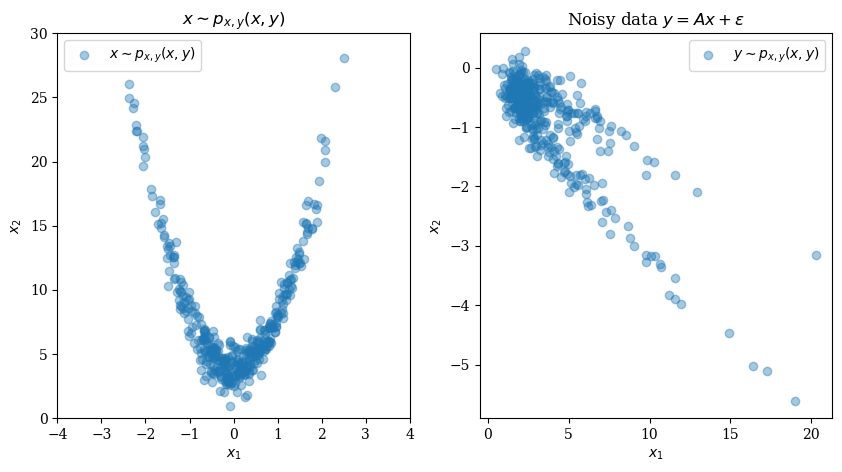

In [24]:
Y_train = reshape(A * reshape(X_train, :, n_train), nx, ny, n_in, n_train)
Y_train += .2f0 * randn(Float32, nx, ny, n_in, n_train)

fig = figure(figsize=(10,5)); 
subplot(1,2,1); title(L"x \sim p_{x,y}(x,y)")
scatter(X_train[1,1,1,1:plot_num], X_train[1,1,2,1:plot_num]; alpha=0.4, label = L"x \sim p_{x,y}(x,y)");
xlabel(L"x_1"); ylabel(L"x_2");
xlim(-4,4); ylim(0,30);
legend();

subplot(1,2,2); title(L"Noisy data $y = Ax + \epsilon$")
scatter(Y_train[1,1,1,1:plot_num], Y_train[1,1,2,1:plot_num]; alpha=0.4, label = L"y \sim p_{x,y}(x,y)");
xlabel(L"x_1"); ylabel(L"x_2");
legend();

## Conditional Normalizing Flows for Joint and Conditional sampling. 
Pairing joint distribution training with Conditional Normalizing Flows allows us to sample from the conditional distribution and therefore the posterior distribution of an inverse problem. We will use the Conditional Normalizing Flow architecture given by [HINT (Kruse, Jakob, et al.)](https://arxiv.org/pdf/1905.10687.pdf).

The HINT architecture implements:
* HINT recursive couplying layer for increased expressiveness
* HINT conditional couplying layer for conditional samplying
* Other layers: ActNorms, 1x1 Convolutions


## Training a Conditional Normalizing Flow

A Conditional Normalizing Flow is trained by first learning the joint distribution $p(x,y)$ which is done in the same way as non-conditional Normalizing Flow namely: minimizing the negative log likelihood.


$$\underset{\mathbf{\theta}}{\operatorname{argmin}}   \frac{1}{N} \sum_{x \in X_{train},y \in Y_{train}} \left[\frac{1}{2}\|f_\theta(x,y)\|_2^2 - \log \, \left| \, \det \frac{\partial f_\theta}{\partial x \partial y} \, \right| \, \right]. $$



In [28]:
function loss(H, X, Y)
    batch_size = size(X)[end] 
    
    Zx, Zy, logdet = H.forward(X, Y)
    l2_loss = 0.5 * norm(tensor_cat(Zx, Zy))^2 / batch_size  #likelihood under Normal Gaussian training 
    
    #gradients under Normal Gaussian training
    dZx = Zx / batch_size 
    dZy = Zy / batch_size 
    
    H.backward(dZx, dZy, Zx, Zy) #sets gradients of G wrt output and also logdet terms
    
    return (l2_loss, logdet)
end

loss (generic function with 2 methods)

In [29]:
batchsize = 64

# Define network
n_hidden  = 64
depth     = 10
  
# Construct HINT network
H = NetworkConditionalHINT(n_in, n_hidden, depth; k1=1, k2=1, p1=0, p2=0)

# Training
maxiter = 900
lr      = 5f-4
lr_decay_step = 90

#compose adam optimizer with exponential learning rate decay 
opt = Flux.Optimiser(ExpDecay(lr, .9f0, lr_decay_step, 1f-6), Flux.ADAM(lr))

loss_l2_list    = zeros(maxiter)
loss_logdett_list = zeros(maxiter)

for j=1:maxiter

    # Evaluate objective and gradients
    X = sample_banana(batchsize)
    Y = reshape(A * reshape(X, :, batchsize), nx, ny, n_in, batchsize)
    Y += .2f0 * randn(Float32, nx, ny, n_in, batchsize)

    losses = loss(H, X, Y)
    loss_l2_list[j]    = losses[1]
    loss_logdet_list[j] = losses[2]

    # Update params
    for p in get_params(H)
        Flux.update!(opt, p.data, p.grad)
    end
end

Iter : iteration=1/900, batch=; f l2 = 1.0023808479309082; f lgdet = -5.432241916656494; f nll objective = 6.434622764587402
Iter : iteration=2/900, batch=; f l2 = 2.0413854122161865; f lgdet = -5.106913089752197; f nll objective = 7.148298501968384
Iter : iteration=3/900, batch=; f l2 = 8.09544849395752; f lgdet = -4.838974952697754; f nll objective = 12.934423446655273
Iter : iteration=4/900, batch=; f l2 = 2.6780431270599365; f lgdet = -4.974357604980469; f nll objective = 7.652400732040405
Iter : iteration=5/900, batch=; f l2 = 2.3868367671966553; f lgdet = -4.78190803527832; f nll objective = 7.168744802474976
Iter : iteration=6/900, batch=; f l2 = 1.0491790771484375; f lgdet = -4.942286491394043; f nll objective = 5.9914655685424805
Iter : iteration=7/900, batch=; f l2 = 1.4398808479309082; f lgdet = -4.804734230041504; f nll objective = 6.244615077972412
Iter : iteration=8/900, batch=; f l2 = 1.1018974781036377; f lgdet = -4.606128215789795; f nll objective = 5.708025693893433
I

Iter : iteration=66/900, batch=; f l2 = 1.878933310508728; f lgdet = 0.6111005544662476; f nll objective = 1.2678327560424805
Iter : iteration=67/900, batch=; f l2 = 2.03920316696167; f lgdet = 0.6075456142425537; f nll objective = 1.4316575527191162
Iter : iteration=68/900, batch=; f l2 = 2.0049784183502197; f lgdet = 0.514026403427124; f nll objective = 1.4909520149230957
Iter : iteration=69/900, batch=; f l2 = 1.8434553146362305; f lgdet = 0.6067017316818237; f nll objective = 1.2367535829544067
Iter : iteration=70/900, batch=; f l2 = 1.4040700197219849; f lgdet = 0.4488537311553955; f nll objective = 0.9552162885665894
Iter : iteration=71/900, batch=; f l2 = 1.5687953233718872; f lgdet = 0.45107269287109375; f nll objective = 1.1177226305007935
Iter : iteration=72/900, batch=; f l2 = 1.997851014137268; f lgdet = 0.4953254461288452; f nll objective = 1.5025255680084229
Iter : iteration=73/900, batch=; f l2 = 2.756524085998535; f lgdet = 0.8934140205383301; f nll objective = 1.863110

Iter : iteration=131/900, batch=; f l2 = 2.3195812702178955; f lgdet = 1.2931485176086426; f nll objective = 1.026432752609253
Iter : iteration=132/900, batch=; f l2 = 1.929672122001648; f lgdet = 1.5753692388534546; f nll objective = 0.35430288314819336
Iter : iteration=133/900, batch=; f l2 = 2.54988431930542; f lgdet = 1.5477005243301392; f nll objective = 1.0021837949752808
Iter : iteration=134/900, batch=; f l2 = 1.4775968790054321; f lgdet = 1.3139125108718872; f nll objective = 0.16368436813354492
Iter : iteration=135/900, batch=; f l2 = 1.39615797996521; f lgdet = 1.4802197217941284; f nll objective = -0.08406174182891846
Iter : iteration=136/900, batch=; f l2 = 1.4423264265060425; f lgdet = 1.6573748588562012; f nll objective = -0.2150484323501587
Iter : iteration=137/900, batch=; f l2 = 1.6008641719818115; f lgdet = 1.0480413436889648; f nll objective = 0.5528228282928467
Iter : iteration=138/900, batch=; f l2 = 1.9101250171661377; f lgdet = 1.2683056592941284; f nll objectiv

Iter : iteration=195/900, batch=; f l2 = 1.583030104637146; f lgdet = 1.755031943321228; f nll objective = -0.17200183868408203
Iter : iteration=196/900, batch=; f l2 = 1.5664191246032715; f lgdet = 2.0017929077148438; f nll objective = -0.43537378311157227
Iter : iteration=197/900, batch=; f l2 = 1.8866682052612305; f lgdet = 1.8796136379241943; f nll objective = 0.007054567337036133
Iter : iteration=198/900, batch=; f l2 = 1.5361614227294922; f lgdet = 1.7912077903747559; f nll objective = -0.25504636764526367
Iter : iteration=199/900, batch=; f l2 = 1.58735191822052; f lgdet = 1.799114465713501; f nll objective = -0.21176254749298096
Iter : iteration=200/900, batch=; f l2 = 2.1107704639434814; f lgdet = 2.067647933959961; f nll objective = 0.04312252998352051
Iter : iteration=201/900, batch=; f l2 = 2.0802512168884277; f lgdet = 1.9211041927337646; f nll objective = 0.15914702415466309
Iter : iteration=202/900, batch=; f l2 = 1.63787043094635; f lgdet = 1.6601548194885254; f nll obj

Iter : iteration=259/900, batch=; f l2 = 1.729622483253479; f lgdet = 2.0607786178588867; f nll objective = -0.3311561346054077
Iter : iteration=260/900, batch=; f l2 = 1.7289801836013794; f lgdet = 2.2068400382995605; f nll objective = -0.47785985469818115
Iter : iteration=261/900, batch=; f l2 = 1.838105320930481; f lgdet = 2.2833008766174316; f nll objective = -0.4451955556869507
Iter : iteration=262/900, batch=; f l2 = 1.6822201013565063; f lgdet = 1.9597854614257812; f nll objective = -0.2775653600692749
Iter : iteration=263/900, batch=; f l2 = 1.9751811027526855; f lgdet = 1.669471025466919; f nll objective = 0.3057100772857666
Iter : iteration=264/900, batch=; f l2 = 1.8407814502716064; f lgdet = 2.1271979808807373; f nll objective = -0.28641653060913086
Iter : iteration=265/900, batch=; f l2 = 1.892317533493042; f lgdet = 2.205629825592041; f nll objective = -0.313312292098999
Iter : iteration=266/900, batch=; f l2 = 2.339667797088623; f lgdet = 2.214060068130493; f nll objecti

Iter : iteration=323/900, batch=; f l2 = 1.8507715463638306; f lgdet = 2.2324318885803223; f nll objective = -0.3816603422164917
Iter : iteration=324/900, batch=; f l2 = 1.6595447063446045; f lgdet = 2.241283416748047; f nll objective = -0.5817387104034424
Iter : iteration=325/900, batch=; f l2 = 1.5698661804199219; f lgdet = 2.3317203521728516; f nll objective = -0.7618541717529297
Iter : iteration=326/900, batch=; f l2 = 1.9593331813812256; f lgdet = 2.340210437774658; f nll objective = -0.3808772563934326
Iter : iteration=327/900, batch=; f l2 = 2.3864710330963135; f lgdet = 2.3259220123291016; f nll objective = 0.060549020767211914
Iter : iteration=328/900, batch=; f l2 = 1.9713159799575806; f lgdet = 2.4313440322875977; f nll objective = -0.4600280523300171
Iter : iteration=329/900, batch=; f l2 = 1.55874502658844; f lgdet = 2.3178956508636475; f nll objective = -0.7591506242752075
Iter : iteration=330/900, batch=; f l2 = 1.8864161968231201; f lgdet = 2.2723727226257324; f nll obj

Iter : iteration=387/900, batch=; f l2 = 1.8031126260757446; f lgdet = 2.4762747287750244; f nll objective = -0.6731621026992798
Iter : iteration=388/900, batch=; f l2 = 2.1237761974334717; f lgdet = 2.435201406478882; f nll objective = -0.31142520904541016
Iter : iteration=389/900, batch=; f l2 = 1.7031326293945312; f lgdet = 2.41416597366333; f nll objective = -0.7110333442687988
Iter : iteration=390/900, batch=; f l2 = 2.0169098377227783; f lgdet = 2.3348793983459473; f nll objective = -0.31796956062316895
Iter : iteration=391/900, batch=; f l2 = 1.7776384353637695; f lgdet = 2.3775086402893066; f nll objective = -0.5998702049255371
Iter : iteration=392/900, batch=; f l2 = 1.8486748933792114; f lgdet = 2.6111814975738525; f nll objective = -0.7625066041946411
Iter : iteration=393/900, batch=; f l2 = 2.047194480895996; f lgdet = 2.4365599155426025; f nll objective = -0.38936543464660645
Iter : iteration=394/900, batch=; f l2 = 1.7095285654067993; f lgdet = 2.4693784713745117; f nll o

Iter : iteration=451/900, batch=; f l2 = 2.033970832824707; f lgdet = 2.5578949451446533; f nll objective = -0.5239241123199463
Iter : iteration=452/900, batch=; f l2 = 1.9057257175445557; f lgdet = 2.52978515625; f nll objective = -0.6240594387054443
Iter : iteration=453/900, batch=; f l2 = 2.385936737060547; f lgdet = 2.5694398880004883; f nll objective = -0.1835031509399414
Iter : iteration=454/900, batch=; f l2 = 2.220759630203247; f lgdet = 2.5963664054870605; f nll objective = -0.3756067752838135
Iter : iteration=455/900, batch=; f l2 = 2.3083620071411133; f lgdet = 2.597417116165161; f nll objective = -0.28905510902404785
Iter : iteration=456/900, batch=; f l2 = 1.8659852743148804; f lgdet = 2.541471242904663; f nll objective = -0.6754859685897827
Iter : iteration=457/900, batch=; f l2 = 1.7290176153182983; f lgdet = 2.6331465244293213; f nll objective = -0.904128909111023
Iter : iteration=458/900, batch=; f l2 = 1.9716377258300781; f lgdet = 2.647036075592041; f nll objective =

Iter : iteration=515/900, batch=; f l2 = 2.1345553398132324; f lgdet = 2.5934014320373535; f nll objective = -0.4588460922241211
Iter : iteration=516/900, batch=; f l2 = 1.9068764448165894; f lgdet = 2.632343292236328; f nll objective = -0.7254668474197388
Iter : iteration=517/900, batch=; f l2 = 2.002641201019287; f lgdet = 2.616551160812378; f nll objective = -0.6139099597930908
Iter : iteration=518/900, batch=; f l2 = 1.937960147857666; f lgdet = 2.627748489379883; f nll objective = -0.6897883415222168
Iter : iteration=519/900, batch=; f l2 = 1.6659940481185913; f lgdet = 2.7911124229431152; f nll objective = -1.125118374824524
Iter : iteration=520/900, batch=; f l2 = 2.1955981254577637; f lgdet = 2.7000420093536377; f nll objective = -0.504443883895874
Iter : iteration=521/900, batch=; f l2 = 1.9581636190414429; f lgdet = 2.7766802310943604; f nll objective = -0.8185166120529175
Iter : iteration=522/900, batch=; f l2 = 2.078335762023926; f lgdet = 2.678040027618408; f nll objective

Iter : iteration=580/900, batch=; f l2 = 2.0670626163482666; f lgdet = 2.896120548248291; f nll objective = -0.8290579319000244
Iter : iteration=581/900, batch=; f l2 = 1.9539726972579956; f lgdet = 2.7519078254699707; f nll objective = -0.7979351282119751
Iter : iteration=582/900, batch=; f l2 = 2.031557083129883; f lgdet = 2.753059148788452; f nll objective = -0.7215020656585693
Iter : iteration=583/900, batch=; f l2 = 1.8151499032974243; f lgdet = 2.7601940631866455; f nll objective = -0.9450441598892212
Iter : iteration=584/900, batch=; f l2 = 1.7202026844024658; f lgdet = 2.7300212383270264; f nll objective = -1.0098185539245605
Iter : iteration=585/900, batch=; f l2 = 2.116960048675537; f lgdet = 2.7565627098083496; f nll objective = -0.6396026611328125
Iter : iteration=586/900, batch=; f l2 = 1.8227661848068237; f lgdet = 2.7535293102264404; f nll objective = -0.9307631254196167
Iter : iteration=587/900, batch=; f l2 = 1.7111318111419678; f lgdet = 2.796673536300659; f nll objec

Iter : iteration=644/900, batch=; f l2 = 2.2720797061920166; f lgdet = 2.6808173656463623; f nll objective = -0.4087376594543457
Iter : iteration=645/900, batch=; f l2 = 2.3631598949432373; f lgdet = 2.76798677444458; f nll objective = -0.4048268795013428
Iter : iteration=646/900, batch=; f l2 = 2.0098118782043457; f lgdet = 2.8371987342834473; f nll objective = -0.8273868560791016
Iter : iteration=647/900, batch=; f l2 = 1.6834399700164795; f lgdet = 2.7828705310821533; f nll objective = -1.0994305610656738
Iter : iteration=648/900, batch=; f l2 = 2.039011001586914; f lgdet = 2.7648568153381348; f nll objective = -0.7258458137512207
Iter : iteration=649/900, batch=; f l2 = 1.902172327041626; f lgdet = 2.6467721462249756; f nll objective = -0.7445998191833496
Iter : iteration=650/900, batch=; f l2 = 2.020862340927124; f lgdet = 2.6723337173461914; f nll objective = -0.6514713764190674
Iter : iteration=651/900, batch=; f l2 = 1.8973249197006226; f lgdet = 2.7703452110290527; f nll objec

Iter : iteration=708/900, batch=; f l2 = 1.907671570777893; f lgdet = 2.8288540840148926; f nll objective = -0.9211825132369995
Iter : iteration=709/900, batch=; f l2 = 1.8615083694458008; f lgdet = 2.7323384284973145; f nll objective = -0.8708300590515137
Iter : iteration=710/900, batch=; f l2 = 2.2975497245788574; f lgdet = 2.7842209339141846; f nll objective = -0.48667120933532715
Iter : iteration=711/900, batch=; f l2 = 1.743632435798645; f lgdet = 2.672292470932007; f nll objective = -0.9286600351333618
Iter : iteration=712/900, batch=; f l2 = 1.7106574773788452; f lgdet = 2.7297823429107666; f nll objective = -1.0191248655319214
Iter : iteration=713/900, batch=; f l2 = 2.317748785018921; f lgdet = 2.783828020095825; f nll objective = -0.4660792350769043
Iter : iteration=714/900, batch=; f l2 = 1.832857370376587; f lgdet = 2.6950342655181885; f nll objective = -0.8621768951416016
Iter : iteration=715/900, batch=; f l2 = 2.0094094276428223; f lgdet = 2.707125663757324; f nll object

Iter : iteration=772/900, batch=; f l2 = 2.1061739921569824; f lgdet = 2.9130685329437256; f nll objective = -0.8068945407867432
Iter : iteration=773/900, batch=; f l2 = 2.31856369972229; f lgdet = 2.8114607334136963; f nll objective = -0.49289703369140625
Iter : iteration=774/900, batch=; f l2 = 1.5752792358398438; f lgdet = 2.8646352291107178; f nll objective = -1.289355993270874
Iter : iteration=775/900, batch=; f l2 = 2.18095064163208; f lgdet = 2.7873730659484863; f nll objective = -0.6064224243164062
Iter : iteration=776/900, batch=; f l2 = 1.7448601722717285; f lgdet = 2.841954469680786; f nll objective = -1.0970942974090576
Iter : iteration=777/900, batch=; f l2 = 2.0762763023376465; f lgdet = 2.794180154800415; f nll objective = -0.7179038524627686
Iter : iteration=778/900, batch=; f l2 = 1.95103120803833; f lgdet = 2.873917818069458; f nll objective = -0.9228866100311279
Iter : iteration=779/900, batch=; f l2 = 2.159766435623169; f lgdet = 2.803961992263794; f nll objective =

Iter : iteration=836/900, batch=; f l2 = 2.0262975692749023; f lgdet = 2.824430465698242; f nll objective = -0.7981328964233398
Iter : iteration=837/900, batch=; f l2 = 1.9925551414489746; f lgdet = 2.8451430797576904; f nll objective = -0.8525879383087158
Iter : iteration=838/900, batch=; f l2 = 1.6606913805007935; f lgdet = 2.69558048248291; f nll objective = -1.0348891019821167
Iter : iteration=839/900, batch=; f l2 = 1.7836992740631104; f lgdet = 2.8464813232421875; f nll objective = -1.0627820491790771
Iter : iteration=840/900, batch=; f l2 = 1.6123676300048828; f lgdet = 2.730106830596924; f nll objective = -1.117739200592041
Iter : iteration=841/900, batch=; f l2 = 1.6818958520889282; f lgdet = 2.8381638526916504; f nll objective = -1.1562680006027222
Iter : iteration=842/900, batch=; f l2 = 2.084038019180298; f lgdet = 2.8285176753997803; f nll objective = -0.7444796562194824
Iter : iteration=843/900, batch=; f l2 = 1.9965736865997314; f lgdet = 2.9022161960601807; f nll object

## Check training objective log 

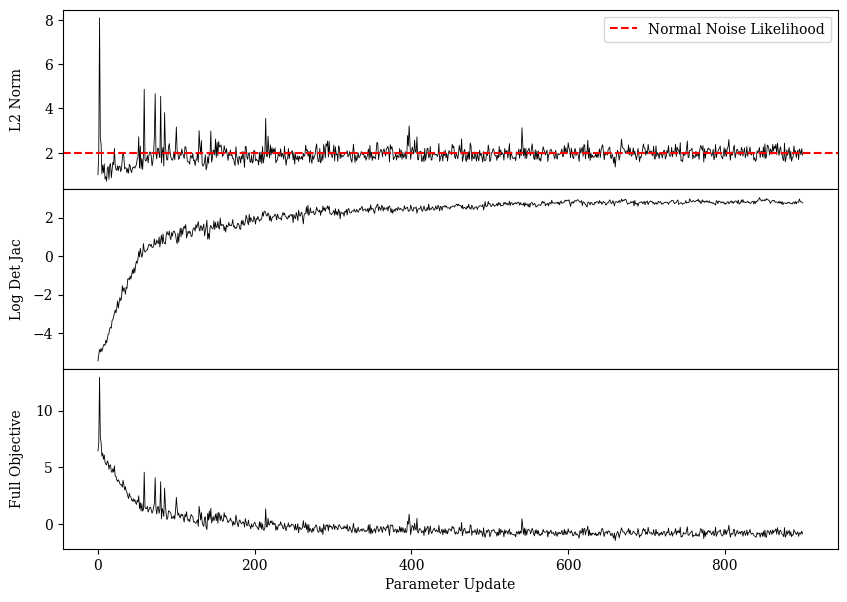

PyObject Text(0.5, 24.000000000000007, 'Parameter Update')

In [30]:
# L2 norm of noise. Note: extra 2 factor since learning a 2 rv. joint distribution
gt_l2 = 0.5 * nx * ny * n_in * 2 

fig, axs = subplots(3, 1, sharex=true, figsize=(10,7))
fig.subplots_adjust(hspace=0)

axs[1].plot(loss_l2_list, color="black", linewidth=0.6); 
axs[1].axhline(y=gt_l2,color="red",linestyle="--",label="Normal Noise Likelihood")
axs[1].set_ylabel("L2 Norm")
axs[1].yaxis.set_label_coords(-0.05, 0.5)
axs[1].legend()

axs[2].plot(loss_logdett_list, color="black", linewidth=0.6); 
axs[2].set_ylabel("Log Det Jac") 
axs[2].yaxis.set_label_coords(-0.05, 0.5) 

axs[3].plot(loss_l2_list - loss_lgdet_list, color="black", linewidth=0.6); 
axs[3].set_ylabel("Full Objective") 
axs[3].yaxis.set_label_coords(-0.05, 0.5)
axs[3].set_xlabel("Parameter Update") 

## Testing a Conditional Normalizing Flow 

The first step in testing a Normalizing Flow is to understand what prior it has learned. In this case, we trained our network to generate samples from a joint distribution so we will first check that these generative samples look like 
 
We start with normal gaussian variables $Zx, Zy \sim \mathcal{N}(0, I)$

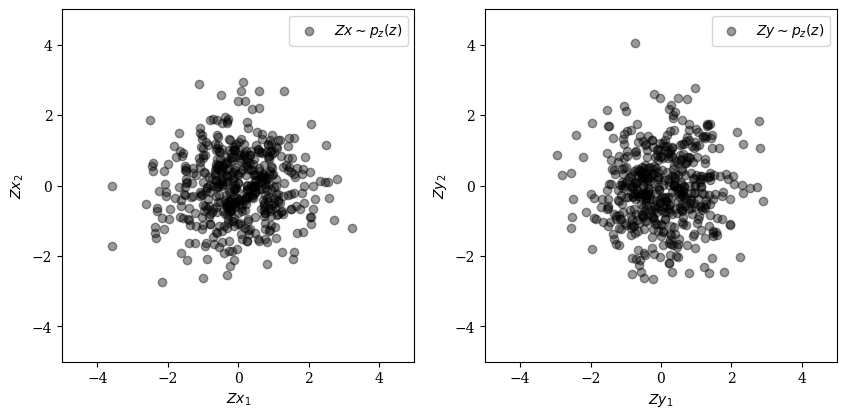

In [31]:
num_test_samples = 500;
Zx_test = randn(Float32,nx,ny,n_in, num_test_samples);
Zy_test = randn(Float32,nx,ny,n_in, num_test_samples);

fig = figure(figsize=(10,5)); 
ax1 = subplot(1,2,1)
scatter(Zx_test[1,1,1,:], Zx_test[1,1,2,:]; alpha=0.4, color="black", label = L"Zx \sim p_{z}(z)");
xlabel(L"Zx_1"); ylabel(L"Zx_2"); xlim(-5,5); ylim(-5,5);
legend(); ax1.set_aspect(1);

ax2 = subplot(1,2,2)
scatter(Zy_test[1,1,1,:], Zy_test[1,1,2,:]; alpha=0.4, color="black", label = L"Zy \sim p_{z}(z)");
xlabel(L"Zy_1"); ylabel(L"Zy_2"); xlim(-5,5); ylim(-5,5);
legend(); ax2.set_aspect(1);

Make generative samples from the joint distribution by passing both Z variables through the inverse network $ x,  y = f^{-1}_\theta(Zx,Zy)$ 

In [32]:
X_test, Y_test = H.inverse(Zx_test, Zy_test);

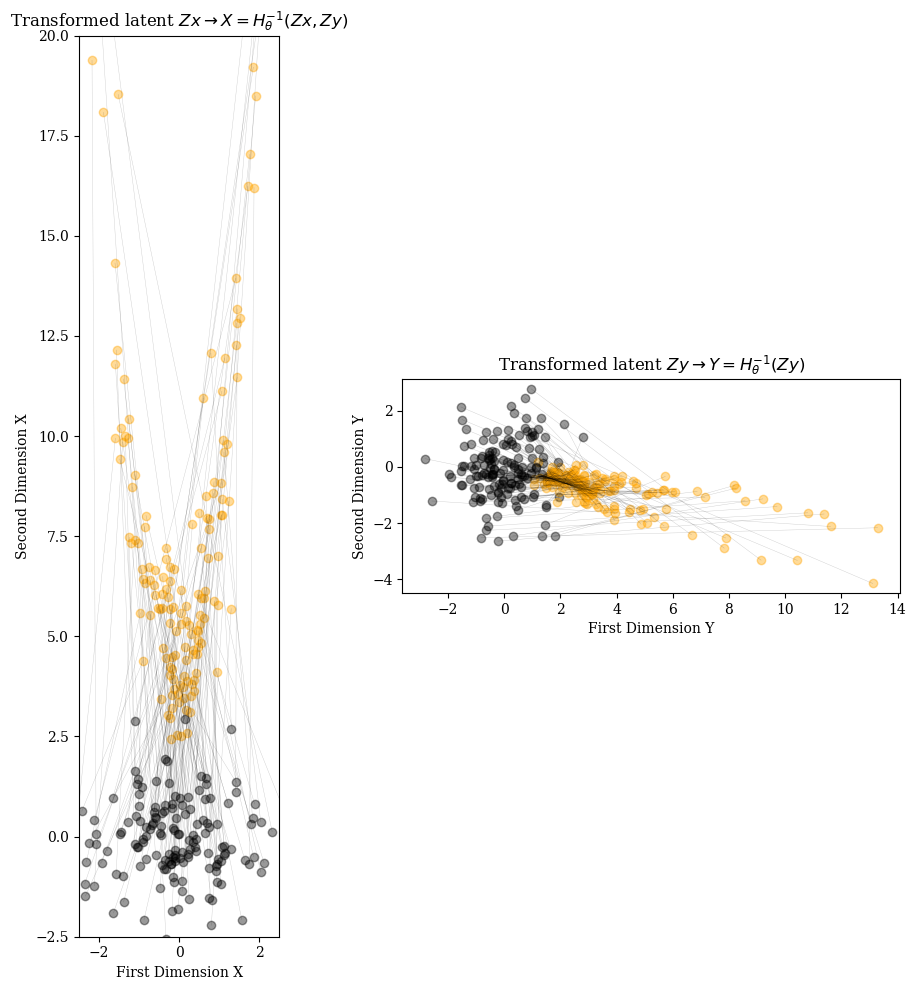

In [33]:
obs_num = 150
start_points = [(Zx_test[1,1,1,i], Zx_test[1,1,2,i]) for i in 1:obs_num]
end_points = [(X_test[1,1,1,i], X_test[1,1,2,i]) for i in 1:obs_num]

# Plot transformed Latent Zx
fig = figure(figsize=(10,10));
ax = fig.add_subplot(1,2,1); title(L"Transformed latent $Zx \rightarrow X=H^{-1}_\theta(Zx, Zy)$");

for line in zip(start_points, end_points)
    plot([line[1][1],line[2][1]], [line[1][2] ,line[2][2]], alpha=0.2, linewidth=0.3, color="black")
    scatter(line[1][1], line[1][2], marker="o",alpha=0.4, color="black")
    scatter(line[2][1], line[2][2], marker="o",alpha=0.4, color="orange")
end
xlabel("First Dimension X"); ylabel("Second Dimension X");
ylim(-2.5,20); xlim(-2.5,2.5); ax.set_aspect(1)

# Plot transformed Latent Zy
start_points = [(Zy_test[1,1,1,i], Zy_test[1,1,2,i]) for i in 1:obs_num]
end_points = [(Y_test[1,1,1,i], Y_test[1,1,2,i]) for i in 1:obs_num]

ax = fig.add_subplot(1,2,2); title(L"Transformed latent $Zy \rightarrow Y=H^{-1}_\theta(Zy)$");
for line in zip(start_points, end_points)
    plot([line[1][1],line[2][1]], [line[1][2] ,line[2][2]], alpha=0.2, linewidth=0.3, color="black")
    scatter(line[1][1], line[1][2], marker="o",alpha=0.4, color="black")
    scatter(line[2][1], line[2][2], marker="o",alpha=0.4, color="orange")
end
xlabel("First Dimension Y"); ylabel("Second Dimension Y");
ax.set_aspect(1)

tight_layout()

Visually compare generative joint samples with joint samples from the ground truth density $x, y \sim p(x,y) $

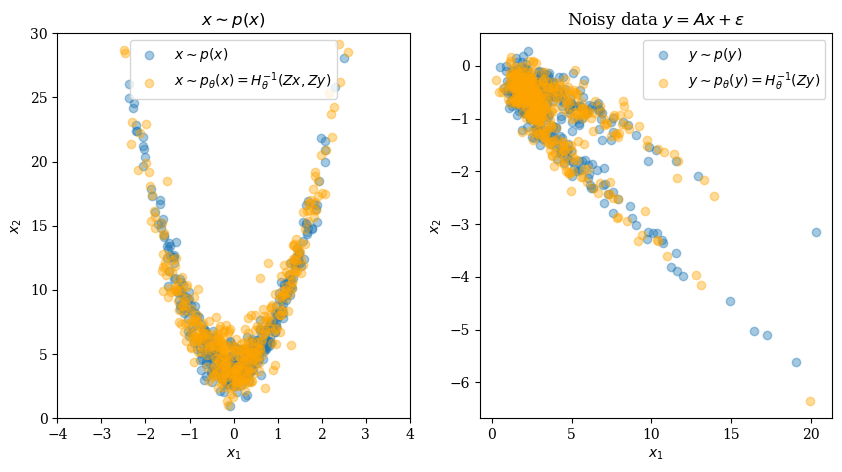

In [35]:
fig = figure(figsize=(10,5)); 
subplot(1,2,1); title(L"x \sim p(x)")
scatter(X_train[1,1,1,1:plot_num], X_train[1,1,2,1:plot_num]; alpha=0.4, label = L"x \sim p(x)");
scatter(X_test[1,1,1,1:plot_num], X_test[1,1,2,1:plot_num]; alpha=0.4, color="orange", label = L"x \sim p_{\theta}(x) = H_\theta^{-1}(Zx, Zy)");
xlabel(L"x_1"); ylabel(L"x_2");
xlim(-4,4); ylim(0,30);
legend();

subplot(1,2,2); title(L"Noisy data $y = Ax + \epsilon$")
scatter(Y_train[1,1,1,1:plot_num], Y_train[1,1,2,1:plot_num]; alpha=0.4, label = L"y \sim p(y)");
scatter(Y_test[1,1,1,1:plot_num], Y_test[1,1,2,1:plot_num]; alpha=0.4, color="orange", label = L"y \sim p_{\theta}(y) = H_\theta^{-1}(Zy)");
xlabel(L"x_1"); ylabel(L"x_2");
legend();

## Test inference of inverse problem given noisy data

After verifying that training was successful, we can proceed to perform inference of the inverse problem. We will first observe a single data $y_{obs}$:

In [37]:
x_star  = sample_banana(1);
y_obs = reshape(A * vec(x_star), nx, ny, n_in, 1);
y_obs += .2f0 * randn(Float32, size(y_obs));

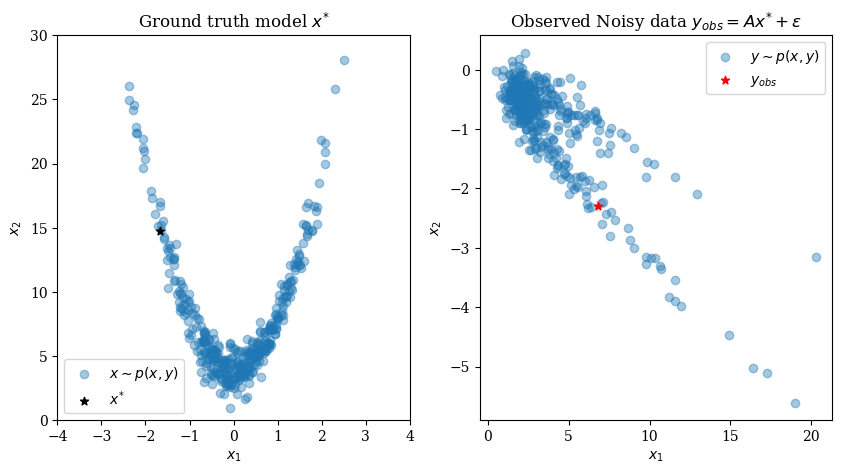

In [38]:
fig = figure(figsize=(10,5)); 
subplot(1,2,1); title(L"Ground truth model $x^{*}$")
scatter(X_train[1,1,1,1:plot_num], X_train[1,1,2,1:plot_num]; alpha=0.4, label = L"x \sim p(x,y)");
scatter(x_star[1,1,1,1], x_star[1,1,2,1]; marker="*", color="black", label = L"x^{*}");
xlabel(L"x_1"); ylabel(L"x_2");
xlim(-4,4); ylim(0,30);
legend();

subplot(1,2,2); title(L"Observed Noisy data $y_{obs} = Ax^{*} + \epsilon$")
scatter(Y_train[1,1,1,1:plot_num], Y_train[1,1,2,1:plot_num]; alpha=0.4, label = L"y \sim p(x,y)");
scatter(y_obs[1,1,1,1], y_obs[1,1,2,1]; marker="*", color="red", label = L"y_{obs}");
xlabel(L"x_1"); ylabel(L"x_2");
legend();

## Form conditional distribution given observed data $p(x|y_{obs})$

Remember that the y-lane in HINT is completely independent of the x-lane. This functionality is implemented in  ``H.forward_Y`` which we will call on our observed data to get the corresponding latent variable $z_y$.


In [40]:
zy_fixed = H.forward_Y(y_obs);

Then we can sample directly from the conditional aka posterior distribution $x \sim p(x|y_{obs})$ We do this by resampling $z_x \sim N(0,I)$ and calling the inverse network $H^{-1}(z_x, z_y)$

In [41]:
#fix zy and resample zx many times to generate samples from the conditional distribution p(x|y)
cond_sampling_size = 50
Zx = randn(Float32, nx, ny, n_in, cond_sampling_size)
X_post = H.inverse(Zx, zy_fixed.*ones(Float32, nx, ny, n_in, cond_sampling_size))[1];

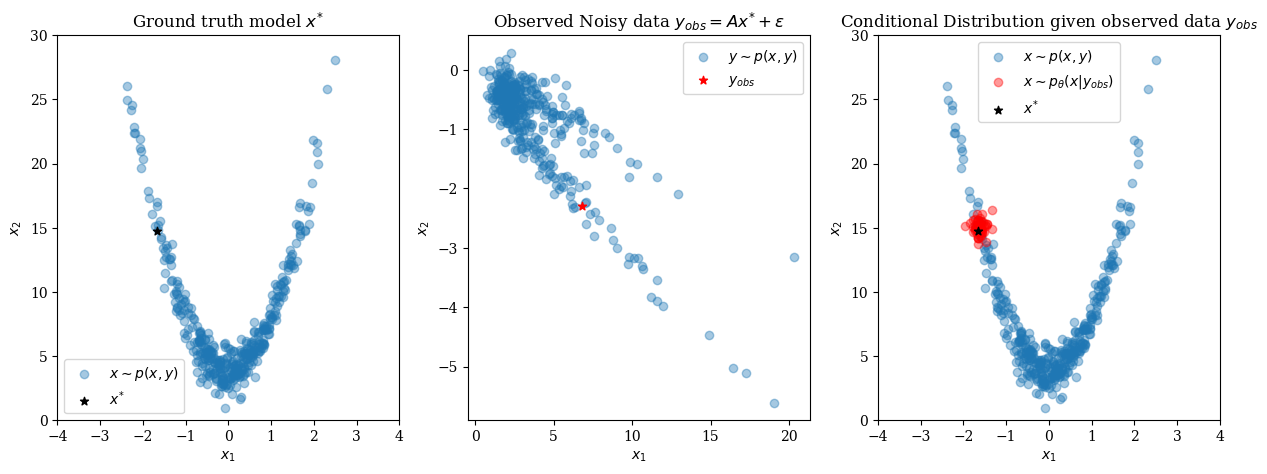

PyObject <matplotlib.legend.Legend object at 0x1680218b0>

In [42]:
fig = figure(figsize=(15,5)); 
subplot(1,3,1); title(L"Ground truth model $x^{*}$")
scatter(X_train[1,1,1,1:plot_num], X_train[1,1,2,1:plot_num]; alpha=0.4, label = L"x \sim p(x,y)");
scatter(x_star[1,1,1,1], x_star[1,1,2,1]; marker="*", color="black", label = L"x^{*}");
xlabel(L"x_1"); ylabel(L"x_2");
xlim(-4,4); ylim(0,30);
legend();

subplot(1,3,2); title(L"Observed Noisy data $y_{obs} = Ax^{*} + \epsilon$")
scatter(Y_train[1,1,1,1:plot_num], Y_train[1,1,2,1:plot_num]; alpha=0.4, label = L"y \sim p(x,y)");
scatter(y_obs[1,1,1,1], y_obs[1,1,2,1]; marker="*", color="red", label = L"y_{obs}");
xlabel(L"x_1"); ylabel(L"x_2");
legend();

subplot(1,3,3); title(L"Conditional Distribution given observed data $y_{obs}$")
scatter(X_train[1,1,1,1:plot_num], X_train[1,1,2,1:plot_num]; alpha=0.4, label = L"x \sim p(x,y)");
scatter(X_post[1,1,1,:], X_post[1,1,2,:]; alpha=0.4, color="red", label = L"x \sim p_{\theta}(x | y_{obs})");
scatter(x_star[1,1,1,1], x_star[1,1,2,1]; marker="*",color="black",  label = L"x^{*}");
xlabel(L"x_1"); ylabel(L"x_2");
xlim(-4,4); ylim(0,30);
legend()

### References 
[1] Villani, Cédric. Optimal transport: old and new. Vol. 338. Berlin: springer, 2009. https://cedricvillani.org/sites/dev/files/old_images/2012/08/preprint-1.pdf:

[2] https://en.wikipedia.org/wiki/Probability_density_function#Dependent_variables_and_change_of_variables

[3] Kingma, Durk P., and Prafulla Dhariwal. "Glow: Generative flow with invertible 1x1 convolutions." Advances in neural information processing systems 31 (2018).
(https://proceedings.neurips.cc/paper/2018/file/d139db6a236200b21cc7f752979132d0-Paper.pdf)

[4] Kruse, Jakob, et al. "HINT: Hierarchical invertible neural transport for density estimation and Bayesian inference." arXiv preprint arXiv:1905.10687 (2019).
https://arxiv.org/pdf/1905.10687.pdf
